<img src='static/img/logo.gif' width=400>

# Хакатон. Задача от `B`e`e`l`i`n`e`

##### `Задача`: необходимо создать модель для бинарной классификации аудиофрагментов с целью определения качества их транскрибации.

___
# <center> <a style='color:gold'>Model inference</a>

___
### <a id=100 style='color:gold'>Содержание</a>

- $\boxed{\text{Импорт данных}}$

    - [Импорт библиотек](#1)

    - [Импорт тестового датасета](#2)

    - [Импорт обученной модели](#3)

- $\boxed{\text{Оценка качества модели}}$

    - [Оценка качества транскрибации по предложению](#4)
    
    - [Оценка качества модели на датасете](#5)


___
### <a id=1 style='color:gold'>Импорт библиотек</a>

In [2]:
import torch
import numpy as np
import pandas as pd
from tqdm import trange
import matplotlib.pyplot as plt
from sklearn.metrics import  roc_auc_score, roc_curve
from transformers import BertTokenizer, BertForSequenceClassification

___
### <a id=2 style='color:gold'>Импорт тестового датасета</a>

In [3]:
FILE_PATH = 'data/data_part1.xlsx'

df = pd.read_excel(FILE_PATH)
df[:5]

,annotation_fastconformer,human_markup,audio_path,label
0,у нас здесь муж много,вот у нас здесь мух много,51b0fadce17e.wav,0
1,понимаешь если бы это был случай он тебя не бо...,понимаешь если бы это было случайно он бы тебя...,42e052ce1540.wav,0
2,вот как ты языков своих трепишь блять они еще ...,вот как ты языком своим треплешь блять они ещё...,42de1bfba887.wav,0
3,и согласен с тем что молчать нельзя и нужно об...,я согласен с тем что молчать нельзя и нужно об...,42dc265ff6f9.wav,0
4,грузинского информата,фрунзенского военкомата,42d97a9d47f1.wav,1


___
### <a id=3 style='color:gold'>Импорт обученной модели</a>

In [ ]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

model = BertForSequenceClassification.from_pretrained('nazarovmichail/sbert_large_transcription_classification').to(device)
tokenizer = BertTokenizer.from_pretrained('nazarovmichail/sbert_large_transcription_classification')

___
### <a id=4 style='color:gold'>Оценка качества транскрибации по предложению</a>

In [5]:
def seq_prediction(sequence: str,
                    model=model,
                    tokenizer=tokenizer) -> None:
    """Функция оценивает качество транскрибации при помощи обученной модели

    Args:
        sequence (str): Текстовый фрагмент транскрибации
        model (_type_, optional): Обученная модель. Defaults to model.
        tokenizer (_type_, optional): Токенайзер. Defaults to tokenizer.
    """

    tokens = tokenizer(sequence, return_tensors="pt").to(device)
    
    with torch.no_grad():
        logits = model(**tokens).logits

    predicted_class = logits.argmax().item()
    if predicted_class:
        print(f'Аудиофрагмент транскрибирован некачественно')
    else:
        print(f'Аудиофрагмент транскрибирован качественно')


sequence = "грузинского информата"

seq_prediction(sequence)

Аудиофрагмент транскрибирован некачественно


___
### <a id=5 style='color:gold'>Оценка качества модели на датасете</a>

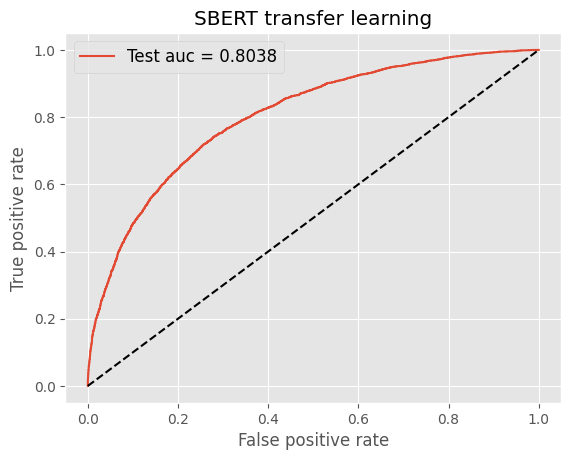

In [17]:
def model_evaluation(
                    test_inputs: list, 
                    test_labels: list,
                    model: BertForSequenceClassification=model,
                    tokenizer: BertTokenizer=tokenizer,
                    device: str=device,
                    batch_size=10,
                    verbose: bool=True) -> np.ndarray:
    """Функция для оценки обученной модели. Изображает ROC-кривую и рассчитывает показатель AUC.

    Args:
        test_inputs (list): Список тестовых транскрибированных предложений
        test_labels (list): Список тестовых лейблов 
        model (BertForSequenceClassification, optional): Обученная модель. Defaults to model.
        tokenizer (BertTokenizer, optional): Токенайзер. Defaults to tokenizer.
        device (str, optional): Устройство для вычислений (cuda / cpu). Defaults to device.
        batch_size (int, optional): Размер батчей. Defaults to 10.
        verbose (bool, optional): Отображение прогрессбара при оценке модели . Defaults to True.

    Returns:
        np.ndarray: Вероятности модели для 1 класса
    """
    
    tokens = tokenizer(test_inputs, padding=True, return_tensors='pt').to(device)
    SAMPLES_N = len(test_inputs)

    total_test_out = torch.zeros(batch_size)
    if verbose:
        for start_idx in trange(0, SAMPLES_N, batch_size):
            input_batch = tokens[start_idx: start_idx + batch_size]
            with torch.no_grad():
                test_out = model(**input_batch).logits[:,1]
                if start_idx == 0:
                    total_test_out = test_out
                else:
                    total_test_out = torch.cat((total_test_out, test_out))
    else:
        for start_idx in range(0, SAMPLES_N, batch_size):
            input_batch = tokens[start_idx: start_idx + batch_size]
            with torch.no_grad():
                test_out = model(**input_batch).logits[:,1]
                if start_idx == 0:
                    total_test_out = test_out
                else:
                    total_test_out = torch.cat((total_test_out, test_out))

    test_proba = torch.nn.functional.softmax(total_test_out, dim=0).detach().cpu().numpy()
    test_auc = roc_auc_score(test_labels, test_proba, )


    plt.style.use('ggplot');
    ax = plt.subplot()
    
    plt.plot(*roc_curve(test_labels, test_proba)[:2], label=f'Test auc = {test_auc:.4f}')
    
    ax.set_xlabel('False positive rate')
    ax.set_ylabel('True positive rate')
    ax.plot([0, 1], [0, 1], '--', color='black',)
    ax.set_title('SBERT transfer learning')
    ax.legend(fontsize='large')

    return test_proba


test_inputs = df['annotation_fastconformer'].tolist()
test_labels = df['label'].tolist()

test_proba = model_evaluation(test_inputs=test_inputs, 
                            test_labels=test_labels, 
                            verbose=False)